In [38]:
## imports
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt


In [39]:
## dataset parameters
number_samples = 100       
difficulty = 4           
problem = 'circles'     # ["classification", "blobs", "gaussian quantiles", "moons", "circles"]
number_features = 2
number_classes = 2
middle_layer = 25           
epochs = 1000              
number_features = 2
number_classes = 2

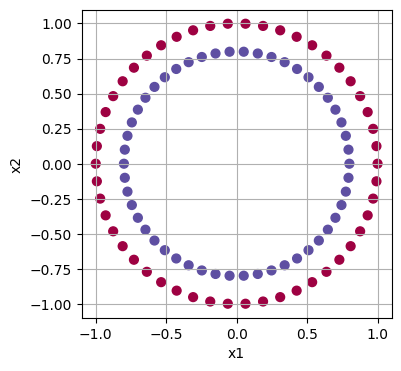

In [40]:
def load_data(problem):
    
    if problem == 'classification':
        clusters = 1 if difficulty < 3 else 2
        informs = 1 if difficulty < 4 else 2
        data = sklearn.datasets.make_classification(
            n_samples=number_samples,
            n_features=number_features,
            n_redundant=0,
            class_sep=1/difficulty,
            n_informative=informs,
            n_clusters_per_class=clusters
        )
    
    if problem == 'blobs':
        data = sklearn.datasets.make_blobs(
            n_samples=number_samples,
            n_features=number_features,
            centers=number_classes,
            cluster_std=difficulty
        )
    
    if problem == 'gaussian quantiles':
        data = sklearn.datasets.make_gaussian_quantiles(
            mean=None,
            cov=difficulty,
            n_samples=number_samples,
            n_features=number_features,
            n_classes=number_classes,
            shuffle=True,
            random_state=None
        )
    
    if problem == 'moons':
        data = sklearn.datasets.make_moons(
            n_samples=number_samples
        )
    
    if problem == 'circles':
        data = sklearn.datasets.make_circles(
        n_samples = number_samples)
     
    return data

data = load_data(problem)
x, y = data

# Input data
plt.figure('Input Data', figsize=(4,4))
plt.scatter(x[:,0], x[:,1], c=y, s=40, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')
plt.grid()
plt.show()    

In [41]:
## helper to show the model prediction
def show_prediction(model, x, y, name='', save=False):
    '''
    Display the labeled data x and a surface of prediction of model
    '''
    
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1  
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    x_temp = np.c_[xx.flatten(), yy.flatten()]
    
    z = model.predict(x_temp)
    
    
    
    plt.figure("Predictions " + name, figsize=(4,4))
    plt.contourf(xx, yy, z.reshape(xx.shape), cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.scatter(x[:, 0], x[:, 1],c=y, s=40, cmap=plt.cm.Spectral) 
    plt.grid()
    
    if save==True: 
        plt.savefig(f'{name}.png', bbox_to_inches='tight')
    
    plt.show()  

### Explore a simple logitic regression as baseling 

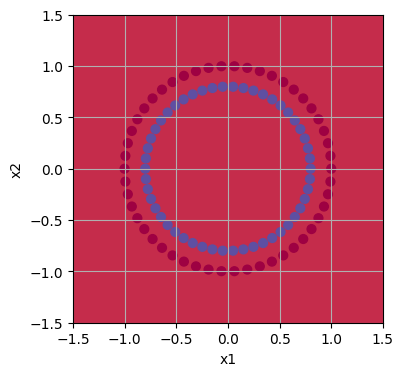

Logistic Regression accuracy:  0.5


In [42]:
## logistic regression 
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(x, y)

show_prediction(clf, x, y, 'Logistic regression')

LR_predictions = clf.predict(x)

print('Logistic Regression accuracy: ', np.sum(LR_predictions == y) / y.shape[0]) 

### Create a simple MLP from scatch to compare with the baseline

In [43]:
## mlp in numpy
def sigmoid(x):
    return 1.0 / (1.0 +np.exp(-x))

## simple neural network
class Neural_Network():
    def __init__(self, n_in, n_hidden, n_out) -> None:  
        # Network dimensions
        self.n_x = n_in
        self.n_h = n_hidden
        self.n_y = n_out
        
        # Parameter initialization
        self.W1 = np.random.randn(self.n_h, self.n_x) * 0.01
        self.b1 = np.zeros((self.n_h, 1)) 
        self.W2 = np.random.randn(self.n_y, self.n_h) * 0.01
        self.b2 = np.zeros((self.n_y, 1))
        
    def forward(self, x):
        '''
        Forward computation
        '''        
        self.Z1 = self.W1.dot(x.T) + self.b1
        self.A1 = np.tanh(self.Z1)
        self.Z2 = self.W2.dot(self.A1) + self.b2
        self.A2 = sigmoid(self.Z2)
        
    def back_prop(self,x ,y):
        '''
        Back-propagate gradient of the loss
        '''
        
        # needed as part of the bce calculation
        m = x.shape[0]  
        
        # These are the derivatives of the BCE-Loss to the respective 
        # variable
        self.dZ2 = self.A2 - y  
        self.dW2 = (1 / m) * np.dot(self.dZ2, self.A1.T)
        self.db2 = (1 / m) * np.sum(self.dZ2 , axis=1, keepdims=True)
        self.dZ1 = np.multiply(np.dot(self.W2.T, self.dZ2), 1 - np.power(self.A1, 2))
        self.dW1 = (1 / m) * np.dot(self.dZ1, x)
        self.db1 = (1 / m) * np.sum(self.dZ1, axis=1, keepdims=True)
        
        
    def train(self, x, y, epochs, learning_rate=1.2):
        '''
        Complete process of learning alternates, forward pass, backward pass and
        parameters update
        ''' 
        
        # needed as part of the bce calculation
        m = x.shape[0]  
        
        for e in range(epochs):
            self.forward(x) 
            
            # Binary crossentropy
            loss = -np.sum(np.multiply(np.log(self.A2), y) + np.multiply(np.log(1-self.A2), (1 - y))) / m
            
            self.back_prop(x, y)
            
            self.W1 -= learning_rate * self.dW1 
            self.b1 -= learning_rate * self.db1
            self.W2 -= learning_rate * self.dW2
            self.b2 -= learning_rate * self.db2
            
            if e % 1000 == 0:
                print('Loss ', e, ' = ', loss)
                
    def predict(self, x):
        '''
        Compute predictions with just a forward pass
        '''
        self.forward(x) 
        
        return np.round(self.A2).astype(np.int) 

### Backpropagation

Unter der Annahme, dass die Verlustfunktion die binäre Kreuzentropie \
(Binary Cross-Entropy, BCE) ist, können die Ableitungen wie folg definiert werden: 

Die binäre Kreuzentropie zwischen den vorhergesagten Ausgaben $\hat{y}$​ und den \
tatsächlichen Labels $y$ ist definiert als:

$\large\mathcal{L}(\hat{y},y)=−\frac{1}{m} \sum_{i=1}^m\left[y^{(i)} \text{log}⁡ (\hat{y}^{(i)})+(1−y^{(i)}) \text{log}⁡ ⁡(1−\hat{y}^{(i)})\right]$


Hierbei ist $m$ die Anzahl der Trainingsbeispiele.

Um die Ableitungen zu berechnen, müssen die Ausdrücke für $\Large\frac{\partial\mathcal{L}}{\partial Z^{[2]}}$​ und $\Large\frac{\partial\mathcal{L}}{\partial Z^{[1]}}$​ gefunden\
werden, da sie die Basis für die Berechnung der Gradienten $\Large\frac{\partial\mathcal{L}}{\partial W^{[2]}}$​, $\Large\frac{\partial\mathcal{L}}{\partial b^{[2]}}$​, $\Large\frac{\partial\mathcal{L}}{\partial W^{[1]}}$​ und $\Large\frac{\partial\mathcal{L}}{\partial b^{[1]}}$​ bilden.

$\Large\frac{\partial\mathcal{L}}{\partial Z^{[2]}}$ berechnet sich wie folgt: 
- $-\frac{1}{m} \left[y \cdot \log(\text{sig}(Z^{[2]})) + (1-y) \cdot log(1 - \text{sig}(Z^{[2]})) \right]$ \
mit $\frac{\partial \text{sig}}{\partial Z^{[2]}} = \text{sig}(Z^{[2]})(1 -\text{sig}(Z^{[2]})) = \hat{y}(1 -\hat{y})$ ergibt sich 

- $- \frac{1}{m} \left[y \cdot \hat{y} (1 - \hat{y}) \cdot \frac{1}{\hat{y}} + (1-y) \cdot (-\hat{y} (1- \hat{y})) \cdot \frac{1}{1-\hat{y}} \right]$

- vereinfachen ergibt: \
$\frac{\partial\mathcal{L}}{\partial Z^{[2]}} = - \frac{1}{m} (\hat{y} - y)$


$\Large\frac{\partial\mathcal{L}}{\partial W^{[2]}}$ berechnet sich wie folgt: 

* Die partielle Ableitung $\Large\frac{\partial\mathcal{L}}{\partial W^{[2]}}$​ beschreibt die Änderung der Verlustfunktion $\mathcal{L}$ \
in Bezug auf die Gewichtungen $W^{[2]}$ in der Ausgangsschicht.

* Es wurde bereits $\frac{\partial\mathcal{L}}{\partial Z^{[2]}}$​ berechnet, was die Änderung der Verlustfunktion in Bezug \
auf die gewichteten Eingaben $Z^{(2)}$ darstellt. Nun muss ermittelt werden, wie sich \
die Gewichtungen $W^{[2]}$ auf die gewichteten Eingaben $Z^{[2]}$ auswirken.

* Mathematisch wird $Z^{[2]}=W^{[2]}⋅A^{[1]}+b^{[2]}$ betrachtet

* Die Gewichtungen $W^{[2]}$ beeinflussen direkt $Z^{[2]}$. \
Daher kann die Kettenregel verwendet werden, um $\frac{\partial\mathcal{L}}{\partial W^{[2]}}$​ zu berechnen: $\frac{\partial\mathcal{L}}{\partial W^{[2]}} = \frac{\partial\mathcal{L}}{\partial Z^{[2]}} \cdot \frac{\partial\ Z^{[2]}}{\partial W^{[2]}} $

* Es wurde bereits $\frac{\partial\mathcal{L}}{\partial Z^{[2]}}$ berechnet, was die Änderung der Verlustfunktion in Bezug auf $Z^{[2]}$ \
darstellt. Jetzt muss $\frac{\partial\ Z^{[2]}}{\partial W^{[2]}}$​ berechnet werden, was die Ableitung der gewichteten Eingaben $Z^{[2]}$ \
nach den Gewichtungen $W^{[2]}$ ist.

* Da $Z^{[2]}$ durch die lineare Transformation $=W^{[2]}⋅A^{[1]}+b^{[2]}$ entsteht, ist die Ableitung $\frac{\partial\ Z^{[2]}}{\partial W^{[2]}}$​\
einfach die Aktivierungen der versteckten Schicht $A^{[1]T}$.

* Daher lautet die gesamte Ableitung: $\Large\frac{\partial \mathcal{L}}{\partial W^{[2]}} = \frac{1}{m} \frac{\partial \mathcal{L}}{\partial Z^{[2]}} \cdot \large A^{[1]T}$

Diese Ableitung gibt an, wie sich die Verlustfunktion $\mathcal{L}$ in Bezug auf die Gewichtungen $W^{[2]}$ ändert, \
und wird verwendet, um die Gewichtungen in der Ausgangsschicht während des Trainingsprozesses zu aktualisieren.


Loss  0  =  0.6931471872245121
Loss  1000  =  0.6931471848873214
Loss  2000  =  0.6931471834257059
Loss  3000  =  0.6931471824929245
Loss  4000  =  0.6931471818879495
Loss  5000  =  0.6931471814898059
Loss  6000  =  0.6931471812238059
Loss  7000  =  0.6931471810430209
Loss  8000  =  0.6931471809176035
Loss  9000  =  0.6931471808284024
Loss  10000  =  0.6931471807630493
Loss  11000  =  0.6931471807135111
Loss  12000  =  0.6931471806745436
Loss  13000  =  0.6931471806427051
Loss  14000  =  0.6931471806157216
Loss  15000  =  0.6931471805920757
Loss  16000  =  0.6931471805707473
Loss  17000  =  0.693147180551037
Loss  18000  =  0.6931471805324569
Loss  19000  =  0.6931471805146578
Loss  20000  =  0.6931471804973813
Loss  21000  =  0.6931471804804284
Loss  22000  =  0.6931471804636389
Loss  23000  =  0.6931471804468784
Loss  24000  =  0.693147180430029


<ipython-input-43-29b68549e0ef>:80: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.round(self.A2).astype(np.int)


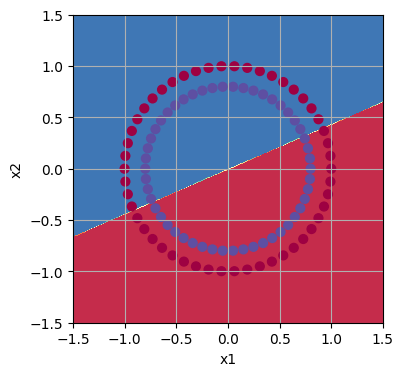

Neural Network accuracy :  0.5


In [44]:
## create the model and train it

nn = Neural_Network(2, middle_layer_sl.value, 1)
nn.train(x, y, epochs_sl.value, 1.2)

show_prediction(nn, x, y, 'Neural network')

nn_predictions = nn.predict(x)  

print("Neural Network accuracy : ", np.sum(nn_predictions == y) / y.shape[0])